In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df = pd.read_csv('SolarPrediction.csv')
df

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00


In [3]:


# Rename 'Data' column to 'DateTime' for clarity
df = df.rename(columns={'Data': 'DateTime'})

# Convert DateTime to pandas datetime
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Convert Time column to datetime.time objects for better handling
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

# Similarly, convert sunrise and sunset times
df['TimeSunRise'] = pd.to_datetime(df['TimeSunRise'], format='%H:%M:%S').dt.time
df['TimeSunSet'] = pd.to_datetime(df['TimeSunSet'], format='%H:%M:%S').dt.time

# Sort by DateTime to ensure proper plotting
df = df.sort_values('DateTime')
df

/var/folders/4q/4w3g7t5n0td3xk6v5zqfpp2w0000gn/T/ipykernel_1763/3483626208.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DateTime'] = pd.to_datetime(df['DateTime'])


,UNIXTime,DateTime,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
7223,1472793006,2016-09-01,19:10:06,2.53,55,30.45,65,155.71,3.37,06:07:00,18:38:00
7257,1472781308,2016-09-01,15:55:08,628.80,63,30.42,58,1.55,6.75,06:07:00,18:38:00
7256,1472781606,2016-09-01,16:00:06,596.57,62,30.42,56,81.70,5.62,06:07:00,18:38:00
7255,1472781907,2016-09-01,16:05:07,577.10,62,30.42,57,53.61,7.87,06:07:00,18:38:00
7254,1472782211,2016-09-01,16:10:11,573.13,62,30.42,58,14.04,3.37,06:07:00,18:38:00
...,...,...,...,...,...,...,...,...,...,...,...
24714,1483206901,2016-12-31,07:55:01,39.30,43,30.31,86,262.51,5.62,06:57:00,17:54:00
24715,1483206602,2016-12-31,07:50:02,39.51,42,30.31,85,265.53,7.87,06:57:00,17:54:00
24716,1483206302,2016-12-31,07:45:02,52.87,42,30.31,84,240.48,4.50,06:57:00,17:54:00
24664,1483221902,2016-12-31,12:05:02,378.41,53,30.33,68,321.95,10.12,06:57:00,17:54:00


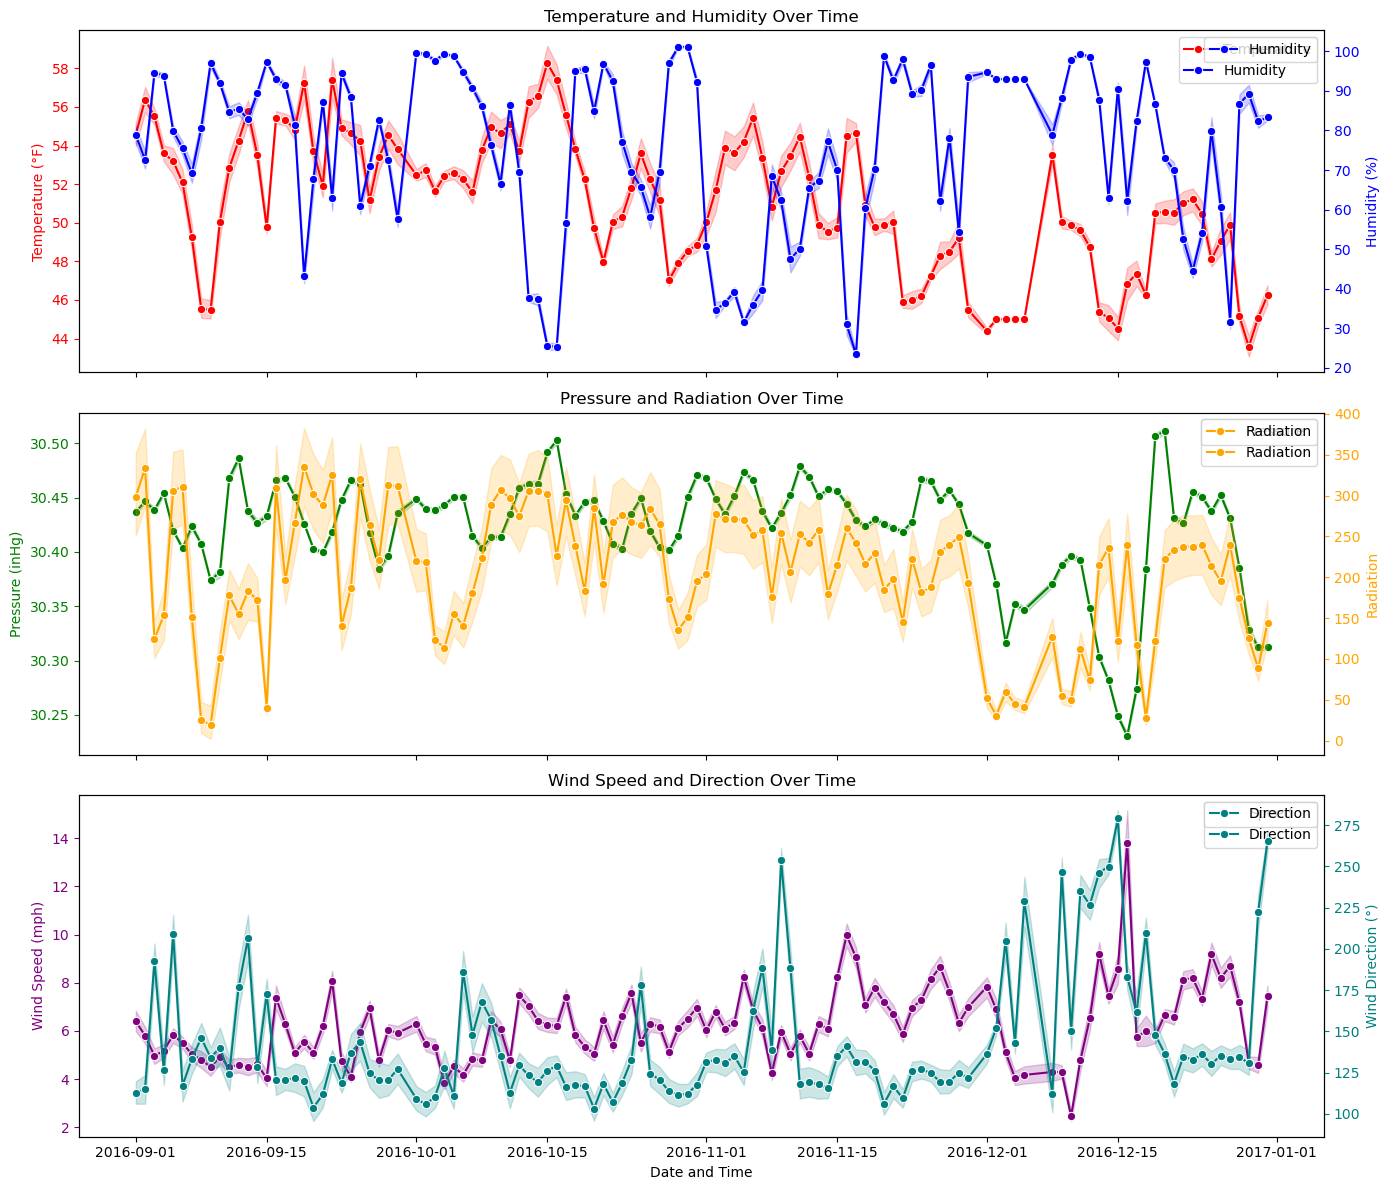

In [4]:

# Alternative visualization: Create a combined plot for related measurements
# Create a figure for related measurements (grouped by type)
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Temperature and Humidity - often related
ax1 = axes[0]
ax1.set_title('Temperature and Humidity Over Time')
ax1_twin = ax1.twinx()  # Create a twin axis for Humidity

# Plot Temperature on left axis
sns.lineplot(x='DateTime', y='Temperature', data=df, marker='o', color='red', label='Temperature', ax=ax1)
ax1.set_ylabel('Temperature (°F)', color='red')
ax1.tick_params(axis='y', colors='red')

# Plot Humidity on right axis
sns.lineplot(x='DateTime', y='Humidity', data=df, marker='o', color='blue', label='Humidity', ax=ax1_twin)
ax1_twin.set_ylabel('Humidity (%)', color='blue')
ax1_twin.tick_params(axis='y', colors='blue')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Pressure and Radiation
ax2 = axes[1]
ax2.set_title('Pressure and Radiation Over Time')
ax2_twin = ax2.twinx()  # Create a twin axis for Radiation

# Plot Pressure on left axis
sns.lineplot(x='DateTime', y='Pressure', data=df, marker='o', color='green', label='Pressure', ax=ax2)
ax2.set_ylabel('Pressure (inHg)', color='green')
ax2.tick_params(axis='y', colors='green')

# Plot Radiation on right axis
sns.lineplot(x='DateTime', y='Radiation', data=df, marker='o', color='orange', label='Radiation', ax=ax2_twin)
ax2_twin.set_ylabel('Radiation', color='orange')
ax2_twin.tick_params(axis='y', colors='orange')

# Add legend
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Wind Speed and Direction
ax3 = axes[2]
ax3.set_title('Wind Speed and Direction Over Time')
ax3_twin = ax3.twinx()  # Create a twin axis for Direction

# Plot Speed on left axis
sns.lineplot(x='DateTime', y='Speed', data=df, marker='o', color='purple', label='Speed', ax=ax3)
ax3.set_ylabel('Wind Speed (mph)', color='purple')
ax3.tick_params(axis='y', colors='purple')

# Plot Direction on right axis
sns.lineplot(x='DateTime', y='WindDirection(Degrees)', data=df, marker='o', color='teal', 
             label='Direction', ax=ax3_twin)
ax3_twin.set_ylabel('Wind Direction (°)', color='teal')
ax3_twin.tick_params(axis='y', colors='teal')

# Add legend
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Format the x-axis with appropriate date formatting for all subplots
plt.xticks(rotation=45)
ax3.set_xlabel('Date and Time')
plt.tight_layout()

plt.show()




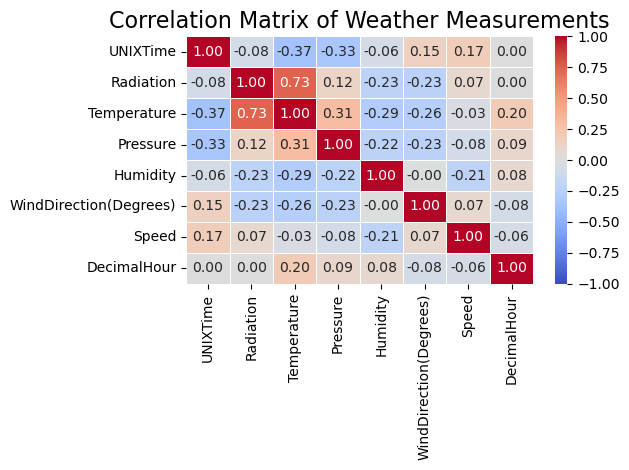

In [5]:
#plot correletions

df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour
df['Minute'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.minute
# Create a decimal hour (hour + minute/60) for better correlation
df['DecimalHour'] = df['Hour'] + df['Minute']/60

# Select only numeric columns for correlation analysis
numeric_columns = ['UNIXTime', 'Radiation', 'Temperature', 'Pressure', 
                   'Humidity', 'WindDirection(Degrees)', 'Speed', 
                   'DecimalHour']
corr_df = df[numeric_columns]

# Calculate the correlation matrix
correlation_matrix = corr_df.corr()

# 1. Create a correlation heatmap
plt.figure()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix of Weather Measurements', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## LSTM NN

In [6]:
import lstm

target_col = 'Radiation'  # Column to predict
window_size = 24  # Use 12 previous time steps (~1 hour) to predict the next value
log_transform=True


X_train, X_val, X_test, y_train, y_val, y_test, scalers, feature_cols, log_transform_info = lstm.prepare_weather_data(
        df, target_col=target_col, window_size=window_size, log_transform=log_transform
    )
target_col_used = target_col
if log_transform_info['applied']:
    target_col_used = f"{target_col}_log"

Added 'Radiation_is_low' feature (threshold: 1.2000)
Log-transformed Radiation -> Radiation_log
X_train shape: (19596, 24, 16)
y_train shape: (19596, 1)
X_val shape: (6533, 24, 16)
y_val shape: (6533, 1)
X_test shape: (6533, 24, 16)
y_test shape: (6533, 1)
Features used: ['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'Radiation_is_low', 'SunriseMinutes', 'SunsetMinutes', 'DaylightMinutes', 'TimeSinceSunrise', 'TimeUntilSunset', 'DaylightPosition', 'TimeMinutesSin', 'TimeMinutesCos', 'HourOfDay']


In [7]:


input_dim = len(feature_cols)  # Number of features
hidden_dim = 256  # Number of hidden units (increased from 64)
num_layers = 2  # Number of LSTM layers
output_dim = 1  # Dimension of output (predicting a single value)
use_combined_loss=True
mse_weight=0.7
mape_weight=0.3
dropout_prob = 0.3
 
# Initialize model
device = torch.device('cpu')
model = lstm.WeatherLSTM(input_dim, hidden_dim, num_layers, output_dim, dropout_prob).to(device)

# Store log transform info in the model
model.log_transform_info = log_transform_info
    

In [8]:
# Train the model with advanced features
model.fit(
        X_train, y_train, X_val, y_val, 
        epochs=100, 
        batch_size=32, 
        learning_rate=0.001, 
        patience=15,  # Increased patience for better convergence 
        device=device,
        scheduler_type="cosine",  # Try cosine annealing scheduler
        weight_decay=1e-4,  # L2 regularization
        clip_grad_norm=1.0,  # Gradient clipping
        use_combined_loss=use_combined_loss,
        mse_weight=mse_weight,
        mape_weight=mape_weight
    )

X_train shape: (19596, 24, 16), y_train shape: (19596, 1)
X_val shape: (6533, 24, 16), y_val shape: (6533, 1)
Using Combined Loss (MSE weight: 0.7, MAPE weight: 0.3)
Regularization settings:
- Dropout probability: 0.3
- L2 regularization (weight decay): 0.0001
- Gradient clipping norm: 1.0
Using CosineAnnealingLR scheduler with T_max=100


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 1/100 - Train loss: 0.151070 - Val loss: 0.063328 - Val RMSE: 0.075977 - Val R²: 0.958167 - Val MAPE: 2.32%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 2/100 - Train loss: 0.086411 - Val loss: 0.069903 - Val RMSE: 0.078158 - Val R²: 0.955731 - Val MAPE: 2.85%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 3/100 - Train loss: 0.081926 - Val loss: 0.073927 - Val RMSE: 0.080174 - Val R²: 0.953418 - Val MAPE: 2.97%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 4/100 - Train loss: 0.080148 - Val loss: 0.079117 - Val RMSE: 0.070943 - Val R²: 0.963527 - Val MAPE: 2.46%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 5/100 - Train loss: 0.078603 - Val loss: 0.065700 - Val RMSE: 0.066472 - Val R²: 0.967980 - Val MAPE: 2.13%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 6/100 - Train loss: 0.076879 - Val loss: 0.079727 - Val RMSE: 0.067379 - Val R²: 0.967100 - Val MAPE: 2.07%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 7/100 - Train loss: 0.076379 - Val loss: 0.101279 - Val RMSE: 0.116733 - Val R²: 0.901250 - Val MAPE: 4.43%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 8/100 - Train loss: 0.075504 - Val loss: 0.070338 - Val RMSE: 0.065932 - Val R²: 0.968498 - Val MAPE: 2.13%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 9/100 - Train loss: 0.075245 - Val loss: 0.076512 - Val RMSE: 0.069560 - Val R²: 0.964935 - Val MAPE: 2.19%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 10/100 - Train loss: 0.074345 - Val loss: 0.063136 - Val RMSE: 0.065803 - Val R²: 0.968621 - Val MAPE: 2.13%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 11/100 - Train loss: 0.074304 - Val loss: 0.066087 - Val RMSE: 0.065680 - Val R²: 0.968738 - Val MAPE: 2.22%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 12/100 - Train loss: 0.073353 - Val loss: 0.065861 - Val RMSE: 0.071956 - Val R²: 0.962479 - Val MAPE: 2.54%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 13/100 - Train loss: 0.074123 - Val loss: 0.067336 - Val RMSE: 0.058411 - Val R²: 0.975275 - Val MAPE: 1.96%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 14/100 - Train loss: 0.073415 - Val loss: 0.077729 - Val RMSE: 0.073386 - Val R²: 0.960972 - Val MAPE: 2.33%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 15/100 - Train loss: 0.073614 - Val loss: 0.063153 - Val RMSE: 0.061089 - Val R²: 0.972956 - Val MAPE: 2.05%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 16/100 - Train loss: 0.073110 - Val loss: 0.075388 - Val RMSE: 0.076444 - Val R²: 0.957652 - Val MAPE: 2.40%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 17/100 - Train loss: 0.074008 - Val loss: 0.070301 - Val RMSE: 0.066046 - Val R²: 0.968389 - Val MAPE: 2.30%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 18/100 - Train loss: 0.072677 - Val loss: 0.066932 - Val RMSE: 0.064609 - Val R²: 0.969749 - Val MAPE: 2.08%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 19/100 - Train loss: 0.072439 - Val loss: 0.072605 - Val RMSE: 0.057179 - Val R²: 0.976307 - Val MAPE: 1.84%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 20/100 - Train loss: 0.072736 - Val loss: 0.059900 - Val RMSE: 0.060911 - Val R²: 0.973113 - Val MAPE: 2.10%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 21/100 - Train loss: 0.072808 - Val loss: 0.065740 - Val RMSE: 0.064336 - Val R²: 0.970004 - Val MAPE: 1.98%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 22/100 - Train loss: 0.072107 - Val loss: 0.068705 - Val RMSE: 0.071280 - Val R²: 0.963180 - Val MAPE: 2.29%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 23/100 - Train loss: 0.072248 - Val loss: 0.071041 - Val RMSE: 0.071423 - Val R²: 0.963032 - Val MAPE: 2.26%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 24/100 - Train loss: 0.072423 - Val loss: 0.061451 - Val RMSE: 0.058048 - Val R²: 0.975581 - Val MAPE: 1.86%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 25/100 - Train loss: 0.071944 - Val loss: 0.082073 - Val RMSE: 0.065313 - Val R²: 0.969087 - Val MAPE: 2.27%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 26/100 - Train loss: 0.073053 - Val loss: 0.075647 - Val RMSE: 0.062875 - Val R²: 0.971352 - Val MAPE: 2.01%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 27/100 - Train loss: 0.072383 - Val loss: 0.065895 - Val RMSE: 0.065631 - Val R²: 0.968784 - Val MAPE: 2.01%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 28/100 - Train loss: 0.071989 - Val loss: 0.064112 - Val RMSE: 0.058217 - Val R²: 0.975439 - Val MAPE: 1.94%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 29/100 - Train loss: 0.072469 - Val loss: 0.064654 - Val RMSE: 0.068682 - Val R²: 0.965815 - Val MAPE: 2.26%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 30/100 - Train loss: 0.072268 - Val loss: 0.060411 - Val RMSE: 0.064786 - Val R²: 0.969583 - Val MAPE: 2.30%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 31/100 - Train loss: 0.072262 - Val loss: 0.068383 - Val RMSE: 0.057395 - Val R²: 0.976127 - Val MAPE: 1.75%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 32/100 - Train loss: 0.071782 - Val loss: 0.070984 - Val RMSE: 0.064224 - Val R²: 0.970109 - Val MAPE: 1.98%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 33/100 - Train loss: 0.071966 - Val loss: 0.072850 - Val RMSE: 0.072357 - Val R²: 0.962059 - Val MAPE: 2.29%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 34/100 - Train loss: 0.071788 - Val loss: 0.059487 - Val RMSE: 0.063758 - Val R²: 0.970541 - Val MAPE: 1.90%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 35/100 - Train loss: 0.071536 - Val loss: 0.071924 - Val RMSE: 0.062355 - Val R²: 0.971823 - Val MAPE: 1.97%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 36/100 - Train loss: 0.071614 - Val loss: 0.084054 - Val RMSE: 0.059487 - Val R²: 0.974356 - Val MAPE: 1.98%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 37/100 - Train loss: 0.071461 - Val loss: 0.061717 - Val RMSE: 0.064549 - Val R²: 0.969805 - Val MAPE: 1.98%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 38/100 - Train loss: 0.071887 - Val loss: 0.059291 - Val RMSE: 0.056902 - Val R²: 0.976536 - Val MAPE: 1.77%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 39/100 - Train loss: 0.071094 - Val loss: 0.069697 - Val RMSE: 0.059040 - Val R²: 0.974740 - Val MAPE: 1.80%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 40/100 - Train loss: 0.071581 - Val loss: 0.070677 - Val RMSE: 0.060615 - Val R²: 0.973374 - Val MAPE: 1.85%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 41/100 - Train loss: 0.070820 - Val loss: 0.058832 - Val RMSE: 0.062949 - Val R²: 0.971284 - Val MAPE: 1.86%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 42/100 - Train loss: 0.070954 - Val loss: 0.067631 - Val RMSE: 0.066955 - Val R²: 0.967513 - Val MAPE: 2.19%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 43/100 - Train loss: 0.070587 - Val loss: 0.068014 - Val RMSE: 0.061658 - Val R²: 0.972449 - Val MAPE: 1.95%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 44/100 - Train loss: 0.070460 - Val loss: 0.065603 - Val RMSE: 0.062231 - Val R²: 0.971935 - Val MAPE: 2.09%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 45/100 - Train loss: 0.070135 - Val loss: 0.062725 - Val RMSE: 0.056130 - Val R²: 0.977169 - Val MAPE: 1.84%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 46/100 - Train loss: 0.070989 - Val loss: 0.062473 - Val RMSE: 0.063954 - Val R²: 0.970359 - Val MAPE: 2.05%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 47/100 - Train loss: 0.070757 - Val loss: 0.058910 - Val RMSE: 0.060276 - Val R²: 0.973671 - Val MAPE: 1.79%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 48/100 - Train loss: 0.069571 - Val loss: 0.067610 - Val RMSE: 0.060558 - Val R²: 0.973424 - Val MAPE: 1.91%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 49/100 - Train loss: 0.070210 - Val loss: 0.063814 - Val RMSE: 0.058899 - Val R²: 0.974860 - Val MAPE: 1.85%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 50/100 - Train loss: 0.069664 - Val loss: 0.073779 - Val RMSE: 0.064859 - Val R²: 0.969514 - Val MAPE: 2.14%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 51/100 - Train loss: 0.069924 - Val loss: 0.070505 - Val RMSE: 0.059627 - Val R²: 0.974235 - Val MAPE: 1.81%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 52/100 - Train loss: 0.069595 - Val loss: 0.063475 - Val RMSE: 0.057708 - Val R²: 0.975866 - Val MAPE: 1.84%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 53/100 - Train loss: 0.069941 - Val loss: 0.058724 - Val RMSE: 0.063094 - Val R²: 0.971152 - Val MAPE: 2.00%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 54/100 - Train loss: 0.069246 - Val loss: 0.072038 - Val RMSE: 0.062232 - Val R²: 0.971934 - Val MAPE: 1.90%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 55/100 - Train loss: 0.069222 - Val loss: 0.061204 - Val RMSE: 0.065083 - Val R²: 0.969304 - Val MAPE: 1.98%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 56/100 - Train loss: 0.069816 - Val loss: 0.070044 - Val RMSE: 0.064058 - Val R²: 0.970263 - Val MAPE: 2.04%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 57/100 - Train loss: 0.069408 - Val loss: 0.061783 - Val RMSE: 0.063960 - Val R²: 0.970354 - Val MAPE: 1.92%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 58/100 - Train loss: 0.069010 - Val loss: 0.056948 - Val RMSE: 0.057466 - Val R²: 0.976069 - Val MAPE: 1.76%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 59/100 - Train loss: 0.069232 - Val loss: 0.070522 - Val RMSE: 0.064064 - Val R²: 0.970257 - Val MAPE: 1.97%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 60/100 - Train loss: 0.068902 - Val loss: 0.066501 - Val RMSE: 0.058263 - Val R²: 0.975400 - Val MAPE: 1.84%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 61/100 - Train loss: 0.068944 - Val loss: 0.065383 - Val RMSE: 0.058032 - Val R²: 0.975595 - Val MAPE: 1.78%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 62/100 - Train loss: 0.069098 - Val loss: 0.062385 - Val RMSE: 0.056141 - Val R²: 0.977159 - Val MAPE: 1.72%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 63/100 - Train loss: 0.069166 - Val loss: 0.065986 - Val RMSE: 0.063594 - Val R²: 0.970692 - Val MAPE: 1.95%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 64/100 - Train loss: 0.068012 - Val loss: 0.062601 - Val RMSE: 0.054228 - Val R²: 0.978690 - Val MAPE: 1.71%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 65/100 - Train loss: 0.068448 - Val loss: 0.066283 - Val RMSE: 0.058872 - Val R²: 0.974883 - Val MAPE: 1.85%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 66/100 - Train loss: 0.068631 - Val loss: 0.069731 - Val RMSE: 0.058426 - Val R²: 0.975262 - Val MAPE: 1.95%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 67/100 - Train loss: 0.068602 - Val loss: 0.061917 - Val RMSE: 0.058346 - Val R²: 0.975330 - Val MAPE: 1.93%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 68/100 - Train loss: 0.068160 - Val loss: 0.066511 - Val RMSE: 0.057742 - Val R²: 0.975838 - Val MAPE: 1.86%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 69/100 - Train loss: 0.068488 - Val loss: 0.060079 - Val RMSE: 0.058794 - Val R²: 0.974950 - Val MAPE: 1.80%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 70/100 - Train loss: 0.067794 - Val loss: 0.063099 - Val RMSE: 0.056772 - Val R²: 0.976643 - Val MAPE: 1.70%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 71/100 - Train loss: 0.068207 - Val loss: 0.069146 - Val RMSE: 0.057483 - Val R²: 0.976054 - Val MAPE: 1.81%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 72/100 - Train loss: 0.068197 - Val loss: 0.067283 - Val RMSE: 0.058992 - Val R²: 0.974781 - Val MAPE: 1.84%


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 73/100 - Train loss: 0.067890 - Val loss: 0.069696 - Val RMSE: 0.060132 - Val R²: 0.973796 - Val MAPE: 1.85%
Early stopping triggered after 73 epochs
Training complete. Best model saved.


WeatherLSTM(
  (lstm): LSTM(16, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (relu): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

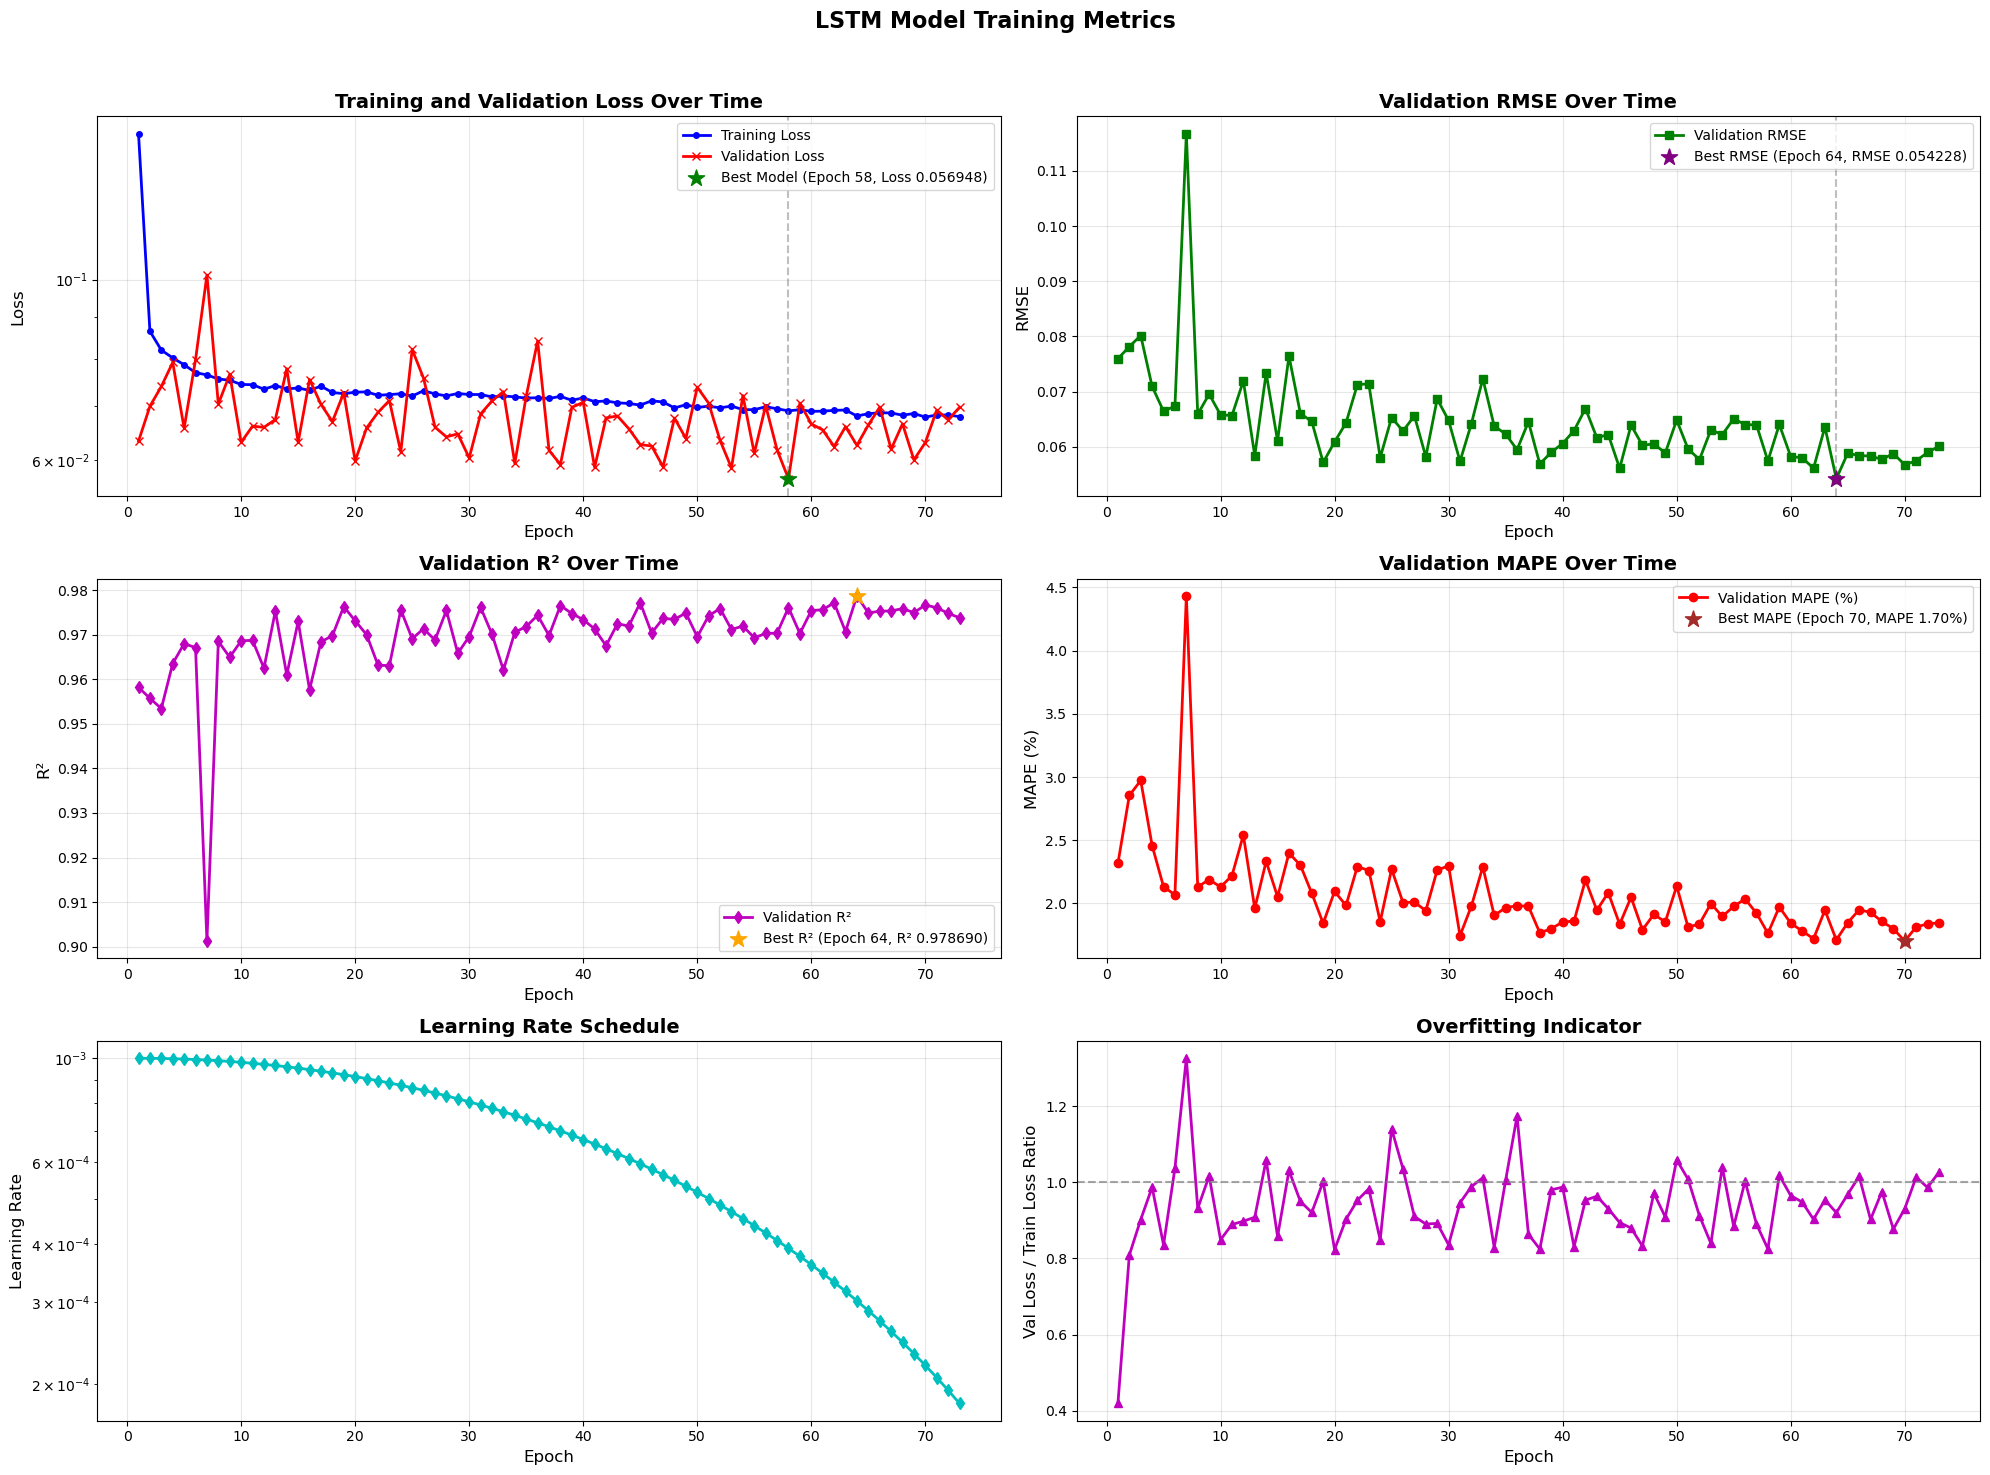

In [9]:
# Visualize training metrics
fig = model.plot_training_history()
plt.show()

In [10]:
# Evaluate on test data
predictions, actuals, metrics = model.evaluate(
        X_test, y_test, device=device, 
        target_scaler=scalers[target_col_used],
        log_transform_info=log_transform_info
    )
    
    
# Calculate RMSE in original scale
rmse = np.sqrt(np.mean((predictions - actuals) ** 2))
#print(f"Test RMSE (original scale): {rmse:.4f}")
    


Scaled Metrics:
Test RMSE: 0.062294
Test R²: 0.971242
Test MAPE (capped at 100%): 18.59%
Applied inverse log transform with epsilon=1e-06

Original Scale Metrics:
Test RMSE: 69.737404
Test R²: 0.931032
Test MAPE (capped at 100%): 19.68%


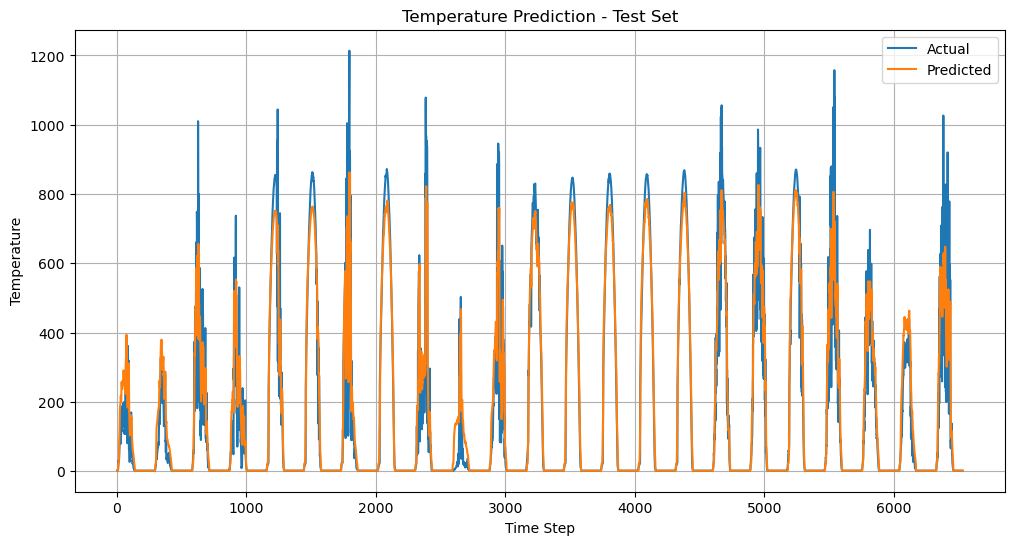

In [11]:
#plot predictions

plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Temperature Prediction - Test Set')
plt.xlabel('Time Step')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

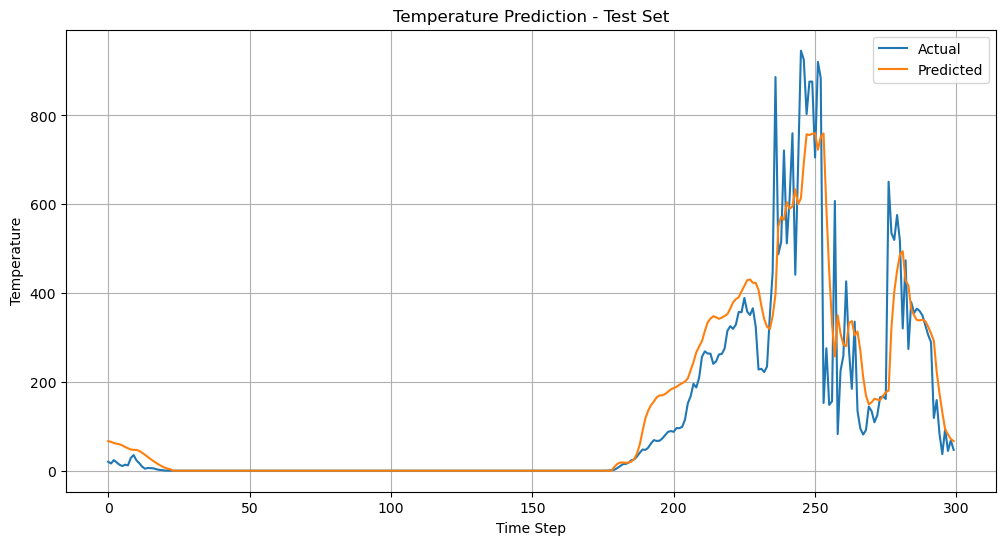

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(actuals[2700:3000], label='Actual')
plt.plot(predictions[2700:3000], label='Predicted')
plt.title('Temperature Prediction - Test Set')
plt.xlabel('Time Step')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

Resampling data to 1min frequency...
Original data points: 6533, After resampling: 6533
Evaluation Summary:
Number of samples (after resampling): 6533
RMSE: 111590.299793
MAE: 53105.054688
MAPE: 37.97%
R²: 0.931032
Correlation: 0.965630


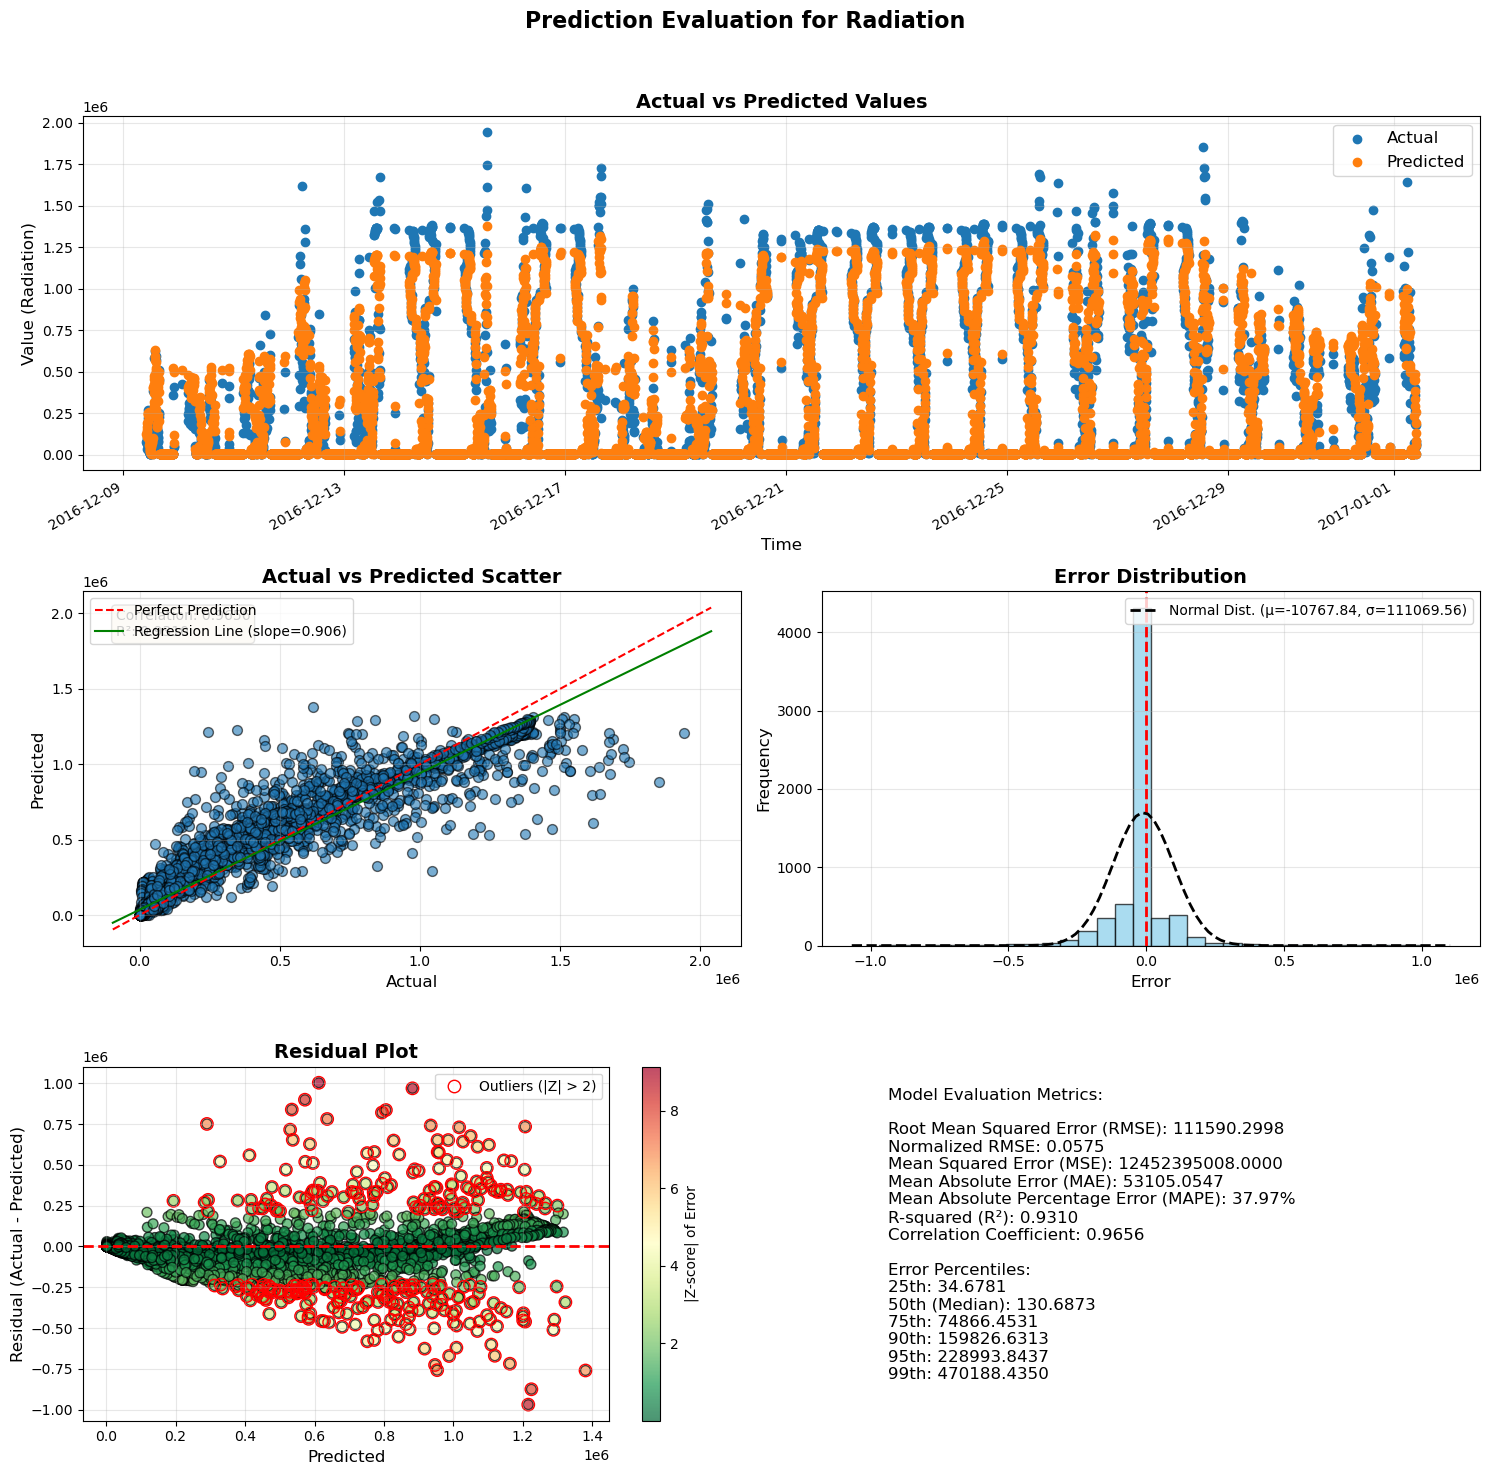

In [14]:
import plot_utils as pu # Make sure you're importing the module correctly

# You can create timestamps if your data has a time component
timestamps = df['UNIXTime'].values[-len(predictions):]  # assuming UNIXTime exists in your df

# Make sure scaler is a dictionary with target_col as key
if not isinstance(scalers, dict):
    scalers_dict = {target_col: scalers}
else:
    scalers_dict = scalers

fig_eval = pu.create_evaluation_dashboard(
    predictions=predictions, 
    actuals=actuals, 
    scalers=scalers_dict,  # Changed from 'scaler' to 'scalers' to match function definition
    target_col=target_col,
    timestamps=timestamps
)


In [19]:
model.save('weather_lstm_model.pt')

AttributeError: 'WeatherLSTM' object has no attribute 'save'

## Multivariate LSTM